In [20]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

import yfinance as yf

from collections import deque
import matplotlib.pylab as plt

#The data already obtained from yahoo finance is imported.
#dataset = read_csv('data/crypto_portfolio.csv',index_col=0)

url = 'https://github.com/Augu0838/MarlFinance/blob/main/sp500_tickers.csv?raw=true'
df = pd.read_csv(url)
single_list = df.iloc[:, 0].tolist()
single_list = single_list[0:80] # Amount of firms included

data = yf.download(single_list, start="2023-01-01", end="2024-01-01")["Close"] # Duration of observable period
data = data.dropna(axis=1, how='any')

from TradingEnv_v2 import TradingEnvironment
from TradingEnv_v2 import portfolio
from Agent_v2 import Agent


N_ASSETS = len(data.columns)
agent = Agent(N_ASSETS)
env = TradingEnvironment(data)

window_size = 180
episode_count = 50
batch_size = 32

rebalance_period = 90 #every 90 days weight change
data_length = len(env.data)
print(data_length)

[*********************100%***********************]  80 of 80 completed


250


In [19]:
for e in range(episode_count):
    agent.is_eval = False
    data_length = len(env.data)

    returns_history = []
    returns_history_equal = []

    rewards_history = []
    equal_rewards = []

    actions_to_show = []

    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0

    for t in range(window_size, data_length, rebalance_period):
        date1 = t - rebalance_period
        # Correlation from 90-180 days
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)

        actions_to_show.append(action[0])

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))

        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []

        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()

Episode 0/50 epsilon 1


ValueError: low >= high

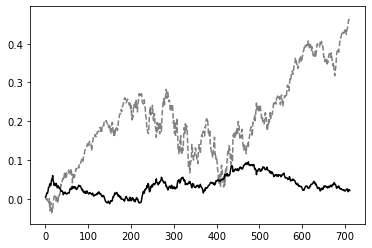

In [7]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'Benchmark', color = 'grey',ls = '--')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'Deep RL portfolio', color = 'black',ls = '-')
plt.show()

/var/folders/bw/7hqp1jn56gz5hffxk2tgzbb80000gn/T/ipykernel_49511/976271092.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  current_cmap.set_bad(color='red')


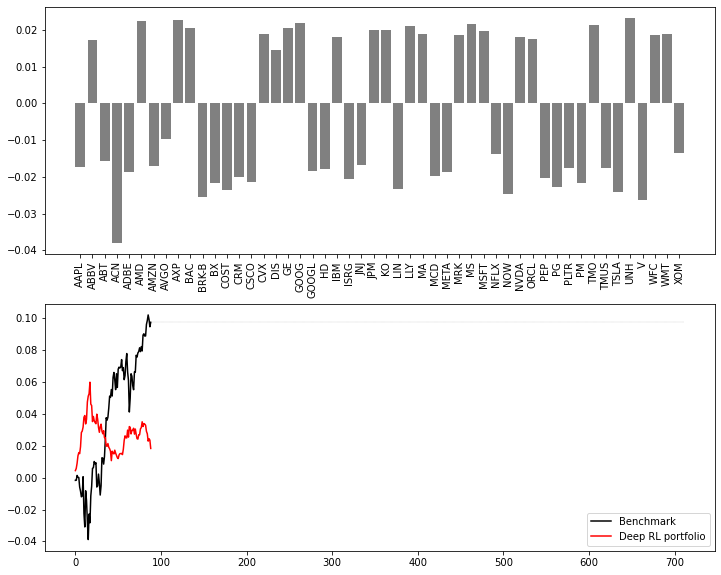

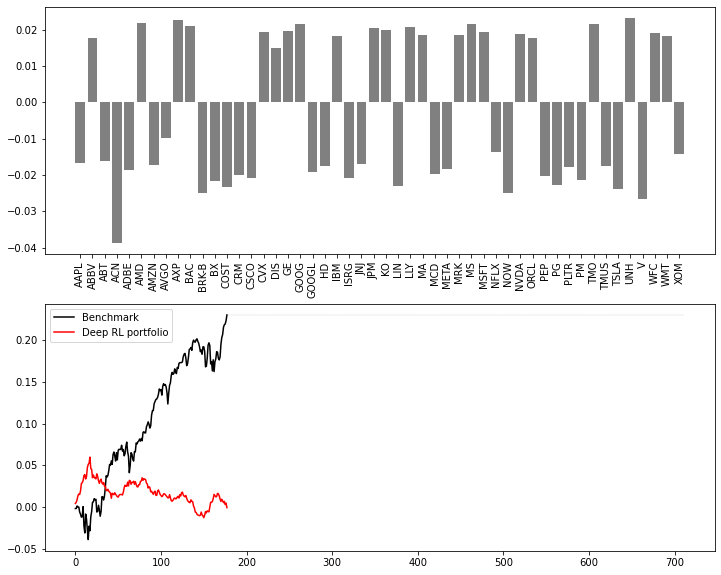

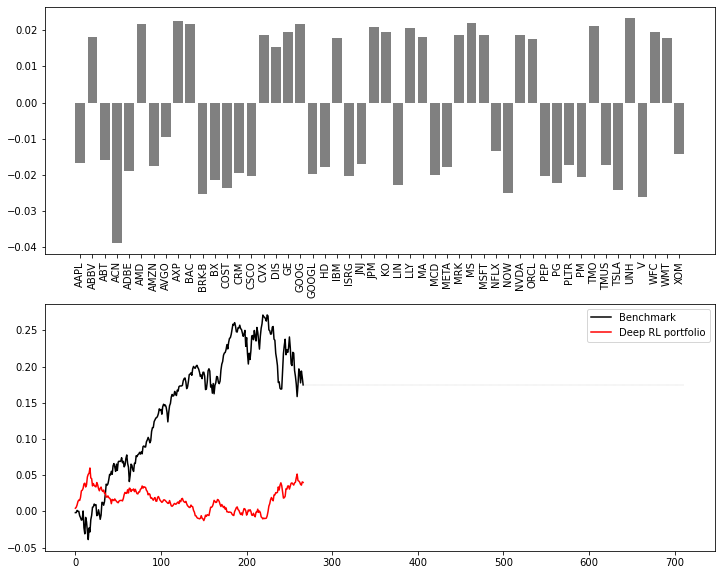

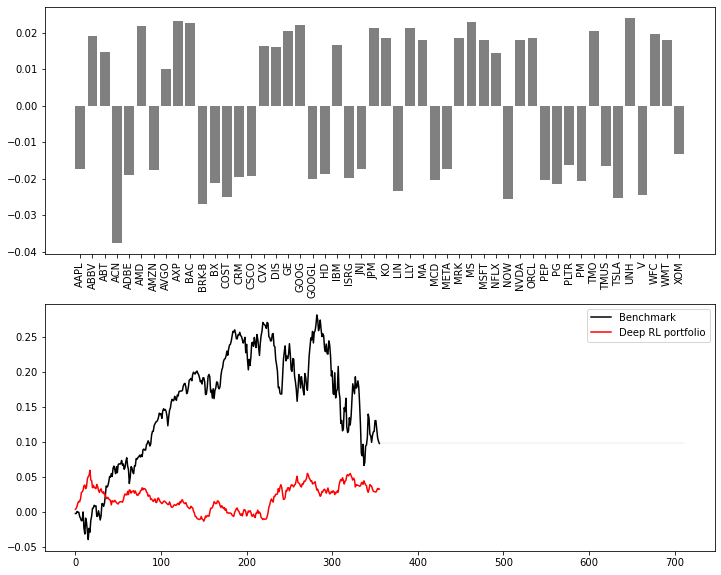

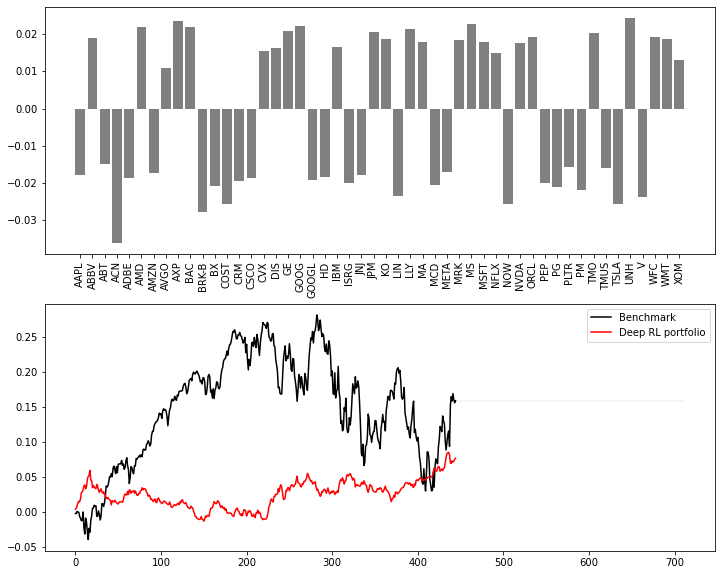

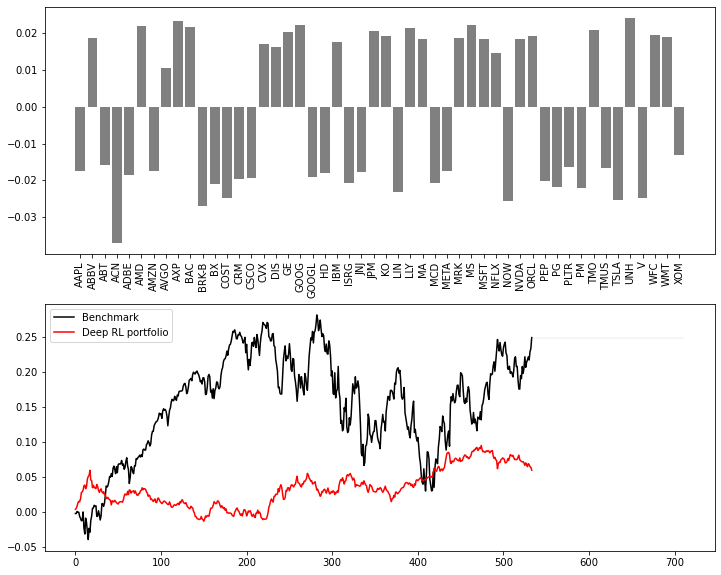

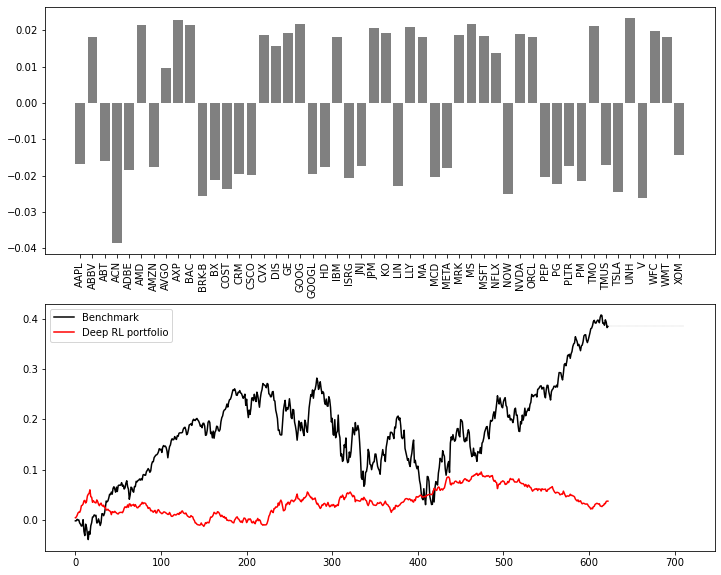

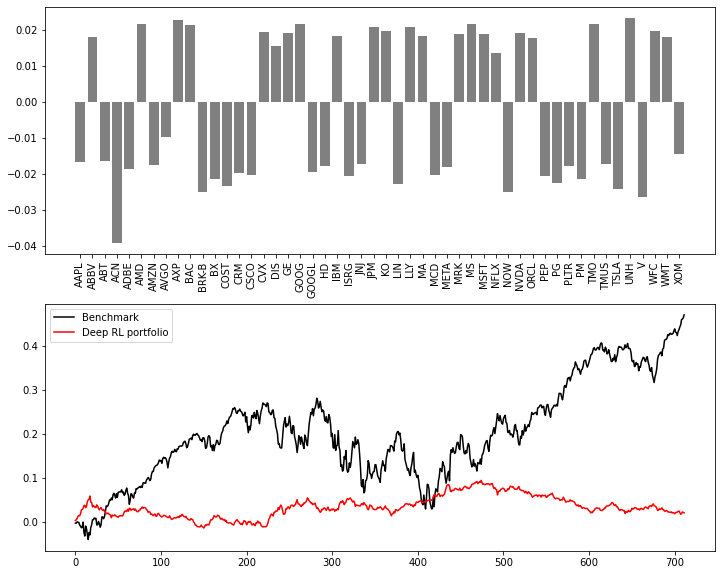

In [12]:
#Plotting the data
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

N = len(np.array([item for sublist in result_equal for item in sublist]).cumsum()) 

for i in range(0, len(actions_rl)):
    current_range = np.arange(0, N)
    current_ts = np.zeros(N)
    current_ts2 = np.zeros(N)

    ts_benchmark = np.array([item for sublist in result_equal[:i+1] for item in sublist]).cumsum()
    ts_target = np.array([item for sublist in result_rl[:i+1] for item in sublist]).cumsum()

    t = len(ts_benchmark)
    current_ts[:t] = ts_benchmark
    current_ts2[:t] = ts_target

    current_ts[current_ts == 0] = ts_benchmark[-1]
    current_ts2[current_ts2 == 0] = ts_target[-1]

    plt.figure(figsize = (12, 10))

    plt.subplot(2, 1, 1)
    plt.bar(np.arange(N_ASSETS), actions_rl[i], color = 'grey')
    plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')

    plt.subplot(2, 1, 2)
    plt.set_cmap(current_cmap)
    plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
    plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = 'Deep RL portfolio')
    plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
    plt.legend()


In [2]:
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))
    
    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()    
    alpha = model.params[0]
    beta = model.params[1]
    
    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [1]:

print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

NameError: name 'print_stats' is not defined